<a href="https://colab.research.google.com/github/candyfirework/test/blob/master/20230620_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 과제
- 전이 학습으로 강아지와 고양이 구분하기
- https://www.kaggle.com/datasets/tongpython/cat-and-dog

In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] ='ko123458' #username
os.environ['KAGGLE_KEY']='8a9e0166d12f7e0ca7fab55e2743219e' #key

In [3]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip -q cat-and-dog.zip

cat-and-dog.zip: Skipping, found more recently modified local copy (use --force to force download)
replace test_set/test_set/cats/_DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [5]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
data_transforms ={
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    'validation':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
}

In [7]:
def target_transforms(target):
  return torch.FloatTensor([target])

In [8]:
# ImageFolder(): 함수쓴
image_datasets = {
    'train': datasets.ImageFolder('/content/training_set/training_set', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('/content/test_set/test_set', data_transforms['validation'], target_transform=target_transforms)
}
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}
print(len(image_datasets['train']), len(image_datasets['validation']))

8005 2023


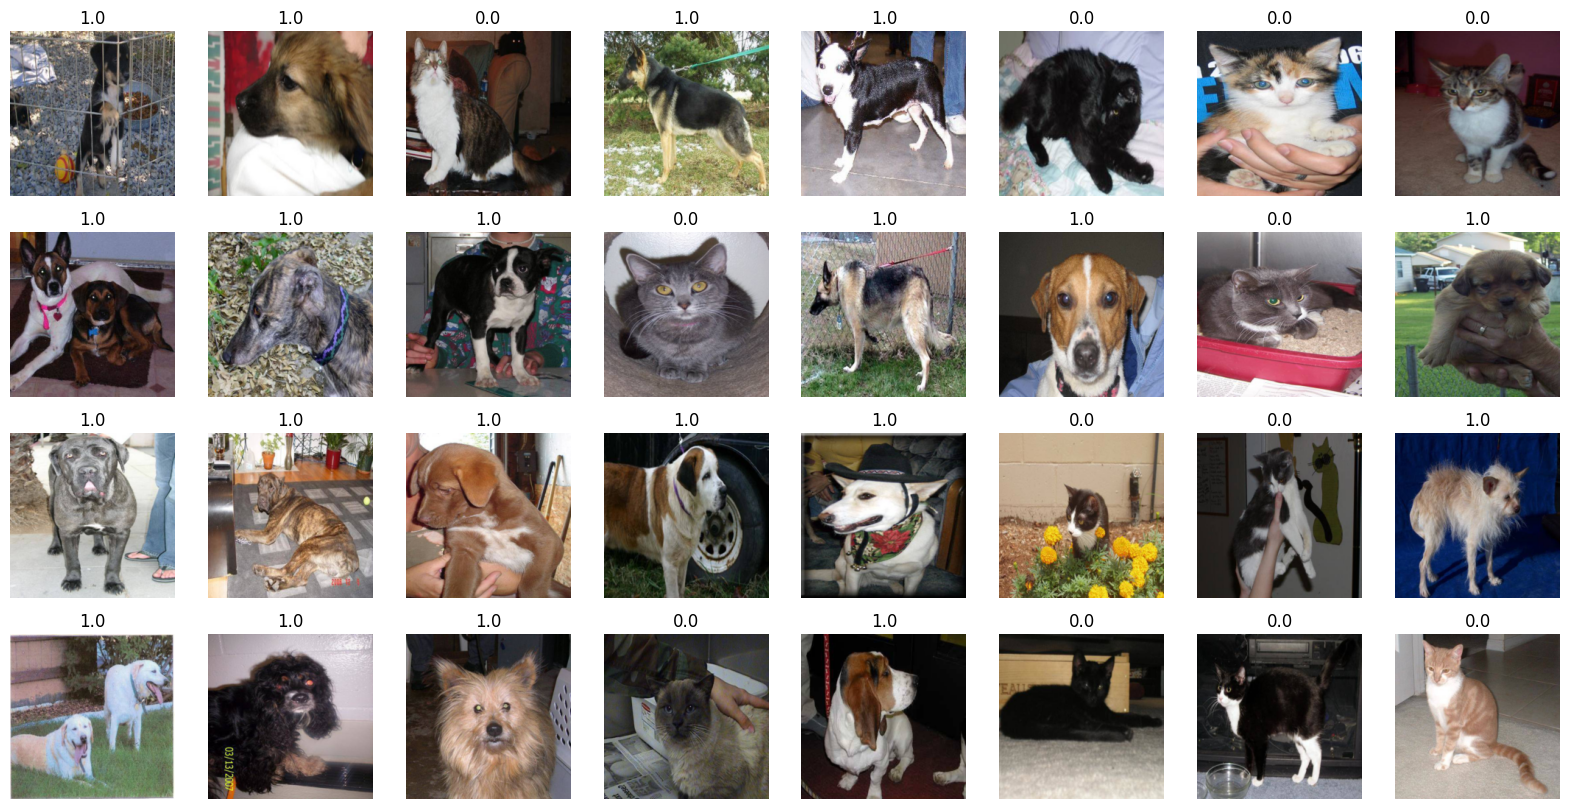

In [9]:
imgs, labels = next(iter(dataloaders['train']))

fig,axes = plt.subplots(4,8,figsize=(20,10))

for img,label,ax in zip(imgs,labels,axes.flatten()):
  ax.set_title(label.item())
  ax.imshow(img.permute(1,2,0))
  ax.axis('off')

In [10]:
# model = models.resnet50(pretrained=True).to (device)
model = models. resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
for param in model. parameters():
  param.requires_grad = False # 가져온 파라미터(W,b)를 업데이트하지 않음

model.fc= nn.Sequential(
    nn.Linear(2048,128),
    nn.ReLU(),
    nn.Linear(128,1),
    nn.Sigmoid()
). to (device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# 학습: fc 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 3
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            sum_losses = sum_losses + loss.item()
            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()
        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/3, Loss: 0.0847, Accuracy: 96.76%
validation: Epoch    1/3, Loss: 0.0836, Accuracy: 96.88%
train     : Epoch    2/3, Loss: 0.0708, Accuracy: 97.33%
validation: Epoch    2/3, Loss: 0.0391, Accuracy: 98.19%
train     : Epoch    3/3, Loss: 0.0692, Accuracy: 97.44%
validation: Epoch    3/3, Loss: 0.0381, Accuracy: 98.73%


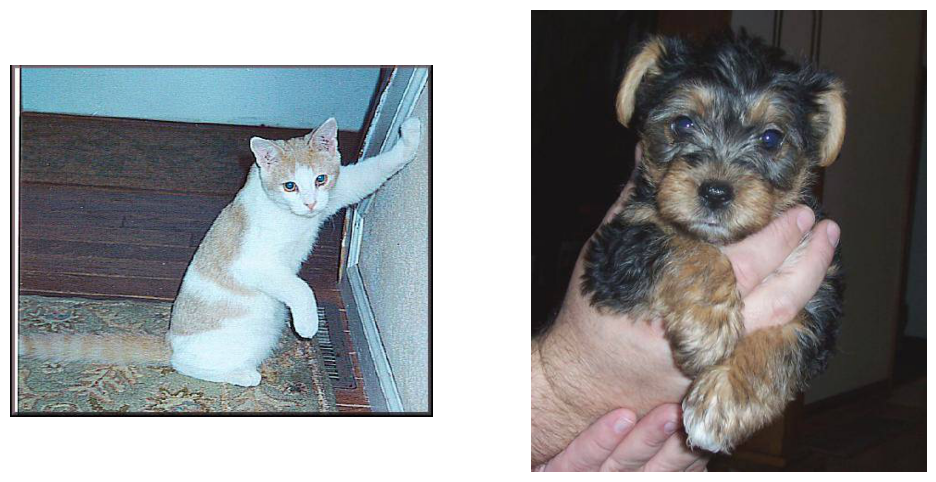

In [18]:
# 테스트
from PIL import Image
img1 =Image.open('/content/test_set/test_set/cats/cat.4001.jpg')
img2 =Image.open('/content/test_set/test_set/dogs/dog.4002.jpg')

fig,axes = plt.subplots(1,2,figsize =(12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1]. axis('off')
plt.show()

In [19]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [20]:
test_batch = torch.stack([img1_input,img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [21]:
y_pred = model(test_batch)
y_pred

tensor([[6.5450e-05],
        [9.6306e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [26]:
9.6306e-01

0.96306

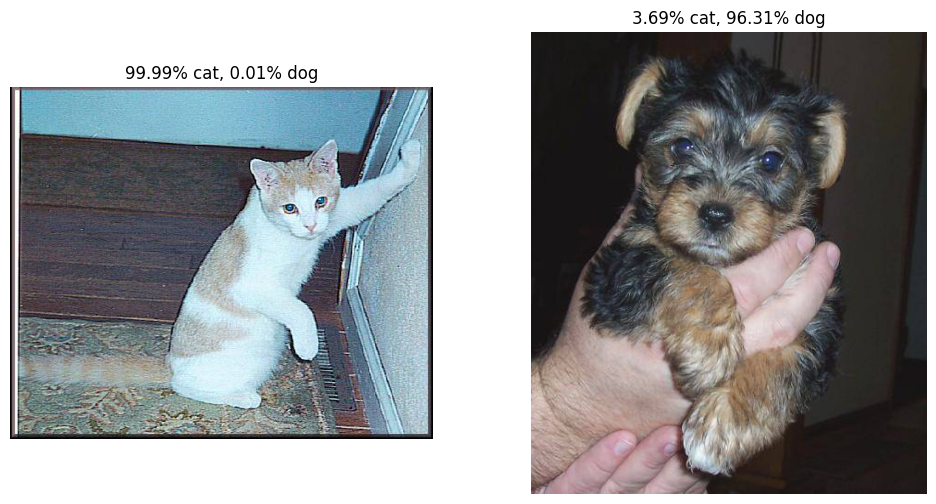

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0]) * 100:.2f}% cat, {y_pred[0, 0] * 100:.2f}% dog')
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].set_title(f'{(1-y_pred[1, 0]) * 100:.2f}% cat, {y_pred[1, 0] * 100:.2f}% dog')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()